In [464]:
import pandas as pd
import matplotlib.pyplot as plt
import credentials
import numpy as np
import sqlconnector as sql
import pickle5 as pickle
from scipy.stats import zscore
from sklearn.decomposition import PCA
from scipy import stats

In [272]:
data = pickle.load(open('data.pickle', "rb"))

In [335]:
# Data cleaning for CSI 300 - download daily historical data from https://www.investing.com/indices/csi300-historical-data

df_csi = pd.read_csv('CSI300.csv')

df_csi = df_csi.apply(lambda x: x.str.replace(',',''))
df_csi = df_csi.apply(lambda x: x.str.replace('K','000'))
df_csi = df_csi.apply(lambda x: x.str.replace('%',''))

df_csi.Date = pd.to_datetime(df_csi.Date)
df_csi = df_csi.sort_values(by='Date')
df_csi = df_csi[df_csi.Date >= dates[0] - pd.Timedelta('5d')]

df_csi = df_csi.reset_index(drop=True)
df_csi.index = df_csi.Date
df_csi.head()

df_csi = df_csi.iloc[:,1:].apply(pd.to_numeric)

In [336]:
# Fill in dates that have no data

idx = pd.date_range(df_csi.index[0], df_csi.index[-1])
df_csi = df_csi.reindex(idx).fillna(method='ffill')

In [337]:
df_csi.head()

,Price,Open,High,Low,Vol.,Change %
2017-01-26,3387.96,3378.26,3395.88,3378.26,65.32,0.36
2017-01-27,3387.96,3378.26,3395.88,3378.26,65.32,0.36
2017-01-28,3387.96,3378.26,3395.88,3378.26,65.32,0.36
2017-01-29,3387.96,3378.26,3395.88,3378.26,65.32,0.36
2017-01-30,3387.96,3378.26,3395.88,3378.26,65.32,0.36


In [342]:
# Calculate one month ahead return

after = df_csi.reindex(df_csi.index + pd.DateOffset(months=1))
after.index = df_csi.index
df_csi['ret'] = (after['Price']/df_csi['Price'] - 1).fillna(method='ffill')

In [343]:
benchmark = df_csi.loc[dates]['ret'].values

In [350]:
data.iloc[:,1:] = data.iloc[:,1:].apply(pd.to_numeric)


In [374]:
data.statistic_date = pd.to_datetime(data.statistic_date)

In [375]:
data.head()

,statistic_date,fund_id,ret,fee,asset,total_liabilities,refundable_deposits,stock_income,transaction_monetary_assets,trustee_payable,...,total_stdev,total_min_return,total_con_fall_days,total_con_rise_days,quarter_return,total_n_earning_days,total_p_earning_days,total_max_drawdown,total_odds,total_return
0,2017-01-31,8,0.035794,0.005,NaN,NaN,NaN,NaN,NaN,NaN,...,0.018549,-0.078231,6.0,9.0,-0.004176,392.0,522.0,0.530764,0.585526,0.706825
1,2017-02-28,8,-0.003764,0.005,NaN,NaN,NaN,NaN,NaN,NaN,...,0.018387,-0.078231,6.0,9.0,0.031469,397.0,534.0,0.530764,0.588172,0.767920
2,2017-03-31,8,-0.028563,0.005,NaN,NaN,NaN,NaN,NaN,NaN,...,0.018186,-0.078231,6.0,9.0,0.027587,408.0,546.0,0.530764,0.585519,0.761266
3,2017-04-30,8,-0.057333,0.005,NaN,NaN,NaN,NaN,NaN,NaN,...,0.018065,-0.078231,7.0,9.0,-0.028563,417.0,555.0,0.530764,0.583934,0.710959
4,2017-05-31,8,0.054007,0.005,NaN,NaN,NaN,NaN,NaN,NaN,...,0.017944,-0.078231,7.0,9.0,-0.084259,430.0,562.0,0.530764,0.579213,0.612864


In [439]:
dates = sorted(data.statistic_date.unique())

In [420]:
features = data.columns[5:]

In [495]:
def quantile(data, features, num_funds=50, month=1):
    '''
    function that computes pnl over time for quantile trading with rebalancing every (t=month) months
        
    inputs: data(pd dataframe), features(list), num_funds(integer) - number of
        funds we hold every month, month(integer) - number of month we are rebalancing
        for
    output: a dict where keys are features and values are list of pnls over time
    '''
    
    dates = sorted(pd.to_datetime(data.statistic_date.unique()))
    pnl = {}
    for feature in features:
        pnl[feature] = []
        for date in dates[::month]:
            df = data[(data.statistic_date == date) & (data[feature].isna() == False)].sort_values(by=feature, ascending=False)
            ret = 0
            funds = df.fund_id[:num_funds]
            if month == 1:
                ret += sum(df.ret[:num_funds])/num_funds
            else:
                
                # Iterate through funds and calculate t - month look ahead return
                for fund in funds:
                    ret_per_fund = 1
                    for i in range(month):
                        if i == 0:
                            ret_per_fund *= (1+df[df.fund_id == fund].ret.values[0]/num_funds)
                        else:
                            month_ret = data[(data.statistic_date == (date + pd.DateOffset(months=i))) & (data.fund_id == fund)].ret.values
                            if month_ret.size > 0:
                                ret_per_fund *= (1 + month_ret[0]/num_funds)
                            else:
                                break
                    ret += ret_per_fund-1
            pnl[feature].append(ret)
    return pnl

In [496]:
pnl = quantile(data, features, 50, 1)

In [497]:
# Sort features in terms of total cumulative pnl and pick top 20

cumul_pnl = {}
for key, val in pnl.items():
    cumul_pnl[key] = sum(val)
    
sort_dic = dict(sorted(cumul_pnl.items(), key=lambda item: item[1]))
top_20_feature = list(sort_dic.keys())[-20:]

In [498]:
top_20_feature

['m6_excess_a',
 'm6_sharpe_a',
 'm6_return',
 'm6_return_Msqr',
 'm6_return_a',
 'm6_adjusted_jensen_a',
 'm6_s_security',
 'm3_tr_a',
 'm6_stock_hm',
 'm6_pain_ratio',
 'm6_tr_a',
 'm6_sor_a',
 'm6_sterling_a',
 'm6_burke_a',
 'm6_ERCVaR',
 'm6_kappa_a',
 'm6_ERVaR',
 'm6_calmar_a',
 'm6_min_return',
 'm3_min_return']

Text(0, 0.5, 'initial capital + cumulative pnl')

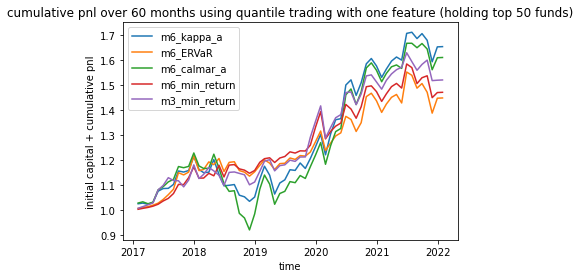

In [507]:
for fea in top_20_feature[-5:]:
    plt.plot(dates,np.cumsum(pnl_top[fea])+1)
plt.legend(top_20_feature[-5:])
plt.title('cumulative pnl over 60 months using quantile trading with one feature (holding top 50 funds)')
plt.xlabel('time')
plt.ylabel('initial capital + cumulative pnl')

In [500]:
excess_pnl = {}
for key, val in pnl.items():
    excess_pnl[key] = val - benchmark
excess_pnl_df = pd.DataFrame(excess_pnl)

In [501]:
excess_pnl_df

,total_liabilities,refundable_deposits,stock_income,transaction_monetary_assets,trustee_payable,org_compensation_payable,paid_up_capital,owner_equity,bank_deposit,other_liabilities,...,total_stdev,total_min_return,total_con_fall_days,total_con_rise_days,quarter_return,total_n_earning_days,total_p_earning_days,total_max_drawdown,total_odds,total_return
0,-0.019141,-0.019141,-0.019141,-0.019141,-0.019141,-0.019141,-0.019141,-0.019141,-0.019141,-0.019141,...,0.004526,-0.003401,-0.007040,-0.001588,-0.005788,-0.005189,-0.001956,0.000497,0.004025,0.001409
1,-0.004924,-0.004924,-0.004924,-0.004924,-0.004924,-0.004924,-0.004924,-0.004924,-0.004924,-0.004924,...,-0.016318,-0.005545,-0.009095,-0.001199,0.000703,-0.004514,-0.000879,-0.009181,-0.002547,-0.003646
2,0.004716,0.004716,0.004716,0.004716,0.004716,0.004716,0.004716,0.004716,0.004716,0.004716,...,-0.024137,-0.002436,-0.001308,0.001078,0.003485,-0.000818,0.000325,-0.012274,-0.005896,-0.006809
3,-0.011826,-0.011826,-0.011826,-0.011826,-0.011826,-0.011826,-0.011826,-0.011826,-0.011826,-0.011826,...,-0.047399,-0.031252,0.006832,-0.020647,-0.008959,0.004930,-0.012154,-0.035909,-0.007615,-0.025314
4,-0.049793,-0.049793,-0.049793,-0.049793,-0.049793,-0.049793,-0.049793,-0.049793,-0.049793,-0.049793,...,-0.009880,-0.023223,-0.004991,-0.014603,0.000516,-0.007846,-0.010378,-0.008788,-0.000285,-0.009847
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,0.027651,0.016792,0.027482,0.025570,0.025656,0.024991,0.022062,0.024842,0.022868,0.021937,...,0.029708,0.001421,0.016522,0.015387,-0.012223,0.021841,0.022744,0.015503,0.027184,0.026594
57,-0.006619,-0.003766,-0.002984,-0.003089,-0.006361,-0.003988,0.002053,-0.003175,-0.016754,0.009124,...,0.011974,-0.011145,0.009277,-0.015035,0.019587,-0.032422,-0.022674,0.002314,-0.017594,-0.011901
58,0.073301,0.080530,0.076637,0.079553,0.075166,0.076831,0.085797,0.080396,0.073744,0.079556,...,0.061427,0.101188,0.072330,0.092131,0.051329,0.096982,0.090588,0.080973,0.077487,0.070586
59,-0.033577,-0.049696,-0.041479,-0.042765,-0.040896,-0.042439,-0.044008,-0.042294,-0.019889,-0.055008,...,-0.051882,-0.031796,-0.042858,-0.032966,-0.074244,-0.004229,-0.018514,-0.028098,-0.045346,-0.032492


In [502]:
def performance_matrix(df,metrics,annualized_factor = 12):

    performance_matrix = []
    for metric in metrics:
        if metric == 'mean':
            performance_matrix.append(df.mean() * annualized_factor)
        elif metric == 'volatility':
            performance_matrix.append(df.std() * np.sqrt(annualized_factor))
        elif metric == 'sharpe':
            performance_matrix.append(df.mean() * annualized_factor / (df.std() * np.sqrt(annualized_factor)))
        elif metric == 'skew':
            performance_matrix.append(df.skew())
        elif metric == 'excess_kurtosis':
            performance_matrix.append(df.kurtosis() - 3)
        elif metric == 'var':
            performance_matrix.append(df.quantile(0.05))
        elif metric =='cvar':
            performance_matrix.append(df[df < df.quantile(0.05)].mean())
        elif metric =='max_drawdown':
            cum_returns = (1 + df).cumprod()
            rolling_max = cum_returns.cummax()
            drawdown = (cum_returns - rolling_max) / rolling_max
            performance_matrix.append(drawdown.min())
        else:
            raise NoSuchMetricError( 'Metric ' + metric + ' is not valid!')
            
    performance_matrix = pd.concat(performance_matrix,axis=1)
    performance_matrix.columns = metrics

    return performance_matrix.T

In [513]:
performance_df = performance_matrix(excess_pnl_df, ['mean', 'volatility', 'sharpe', 'max_drawdown']).transpose()

In [515]:
performance_df.sort_values(by='sharpe', ascending=False).head(10)

,mean,volatility,sharpe,max_drawdown
m6_calmar_a,0.096796,0.111936,0.864745,-0.122380
m6_burke_a,0.092054,0.113696,0.809654,-0.125894
m6_kappa_a,0.092988,0.115136,0.807637,-0.122565
m6_sterling_a,0.091690,0.114710,0.799325,-0.125186
m6_sor_a,0.090380,0.113880,0.793638,-0.121830
m6_tr_a,0.090016,0.114380,0.786989,-0.167662
m6_pain_ratio,0.089322,0.115269,0.774902,-0.134367
m6_ERVaR,0.093276,0.122450,0.761747,-0.153307
m6_ERCVaR,0.092672,0.123332,0.751402,-0.155733
y1_con_rise_days,0.078731,0.107552,0.732023,-0.201088


In [505]:
performance_df.sort_values(by='max_drawdown', ascending=False)

,mean,volatility,sharpe,max_drawdown
m3_info_a,0.051638,0.105699,0.488535,-0.107192
y1_info_a,0.057313,0.098517,0.581752,-0.107946
m6_info_a,0.053831,0.101149,0.532193,-0.111550
m6_corr,0.033591,0.094038,0.357202,-0.112334
y1_corr,0.039582,0.095000,0.416656,-0.113541
...,...,...,...,...
m6_pain_index,-0.000289,0.123514,-0.002341,-0.278171
m6_max_drawdown,0.005598,0.128595,0.043532,-0.284899
m3_VaR,-0.000800,0.123755,-0.006463,-0.293623
total_downsidecap,-0.025495,0.112835,-0.225948,-0.293700


In [506]:
performance_df.sort_values(by='volatility')

,mean,volatility,sharpe,max_drawdown
total_corr,0.037155,0.093379,0.397900,-0.114412
total_corr_spearman,0.038661,0.094031,0.411152,-0.114902
m6_corr,0.033591,0.094038,0.357202,-0.112334
total_n_earning_days,0.040755,0.094080,0.433196,-0.118968
y1_corr,0.039582,0.095000,0.416656,-0.113541
...,...,...,...,...
quarter_return,0.053805,0.133225,0.403867,-0.140279
y1_n_earning_days,0.010183,0.133796,0.076110,-0.249982
year_n_earning_days,-0.013678,0.149725,-0.091356,-0.329388
m6_min_return,inf,NaN,NaN,-0.154451


In [459]:
def quantile_all_features(data, features):
    
    col = features+['fund_id']
    dates = data.statistic_date.unique()
    pnl = []
    hold = []
    for date in dates[1:]:
        ret = 0
        for company in hold:
            try:
                ret += data[(data.statistic_date == date) & (data.fund_id == company)].ret.values[0]*0.05
            except:
                ret += 0
        pnl.append(ret)
        df = data[data.statistic_date == date][col].dropna()
        #print(df.columns)
        df['score'] = stats.zscore(df[features]).sum(axis=1)
        df = df.sort_values(by='score', ascending=False)
        #print(df.fund_id)
        hold = list(df.fund_id[:20])
        #print(hold)
            #print(len(df.fund_id), date)
    return pnl

In [174]:
top_20_feature

['m3_max_drawdown',
 'total_odds',
 'y1_odds',
 'total_omega',
 'y1_tr_a',
 'y1_stock_hm',
 'm3_ERVaR',
 'total_excess_pl',
 'm3_dd_a',
 'm6_hurst',
 'm3_VaR',
 'total_con_fall_days',
 'm3_con_rise_days',
 'm6_s_security',
 'm3_beta',
 'm3_info_a',
 'm6_stock_hm',
 'm3_min_return',
 'm6_downbeta_cl',
 'total_mdd_time']

In [417]:
pnl = quantile(data, features)

In [217]:
pnl_top = quantile(data, features)

In [177]:
pnl_all_feature = quantile_all_features(data,top_20_feature)

Text(0, 0.5, 'dollar')

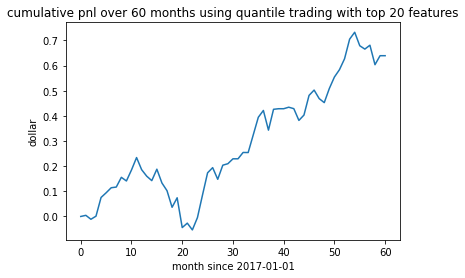

In [180]:
plt.plot(np.cumsum(pnl_all_feature))
plt.title('cumulative pnl over 60 months using quantile trading with top 20 features')
plt.xlabel('month since 2017-01-01')
plt.ylabel('dollar')

In [181]:
pnl_top_5_feature = quantile_all_features(data,top_20_feature[-5:])

Text(0, 0.5, 'dollar')

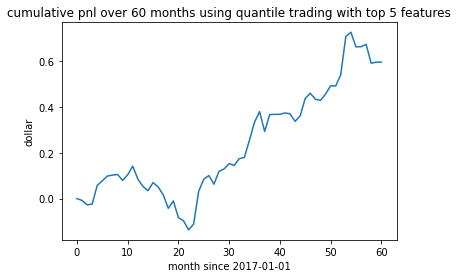

In [183]:
plt.plot(np.cumsum(pnl_top_5_feature))
plt.title('cumulative pnl over 60 months using quantile trading with top 5 features')
plt.xlabel('month since 2017-01-01')
plt.ylabel('dollar')

In [184]:
pnl_top_10_feature = quantile_all_features(data,top_20_feature[-10:])

Text(0, 0.5, 'dollar')

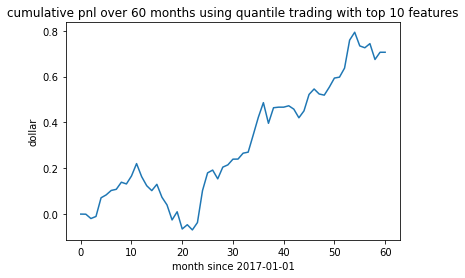

In [185]:
plt.plot(np.cumsum(pnl_top_10_feature))
plt.title('cumulative pnl over 60 months using quantile trading with top 10 features')
plt.xlabel('month since 2017-01-01')
plt.ylabel('dollar')

In [200]:
pnl_all_feature_20_two = quantile_all_features_two_month(data,top_20_feature)

Text(0, 0.5, 'dollar')

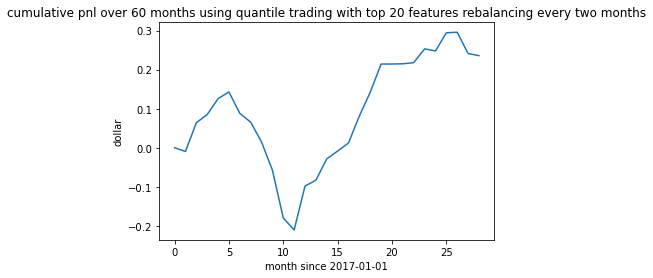

In [201]:
plt.plot(np.cumsum(pnl_all_feature_20_two))
plt.title('cumulative pnl over 60 months using quantile trading with top 20 features rebalancing every two months')
plt.xlabel('month since 2017-01-01')
plt.ylabel('dollar')

In [203]:
pnl_all_feature_10_two = quantile_all_features_two_month(data,top_20_feature[-10:])

Text(0, 0.5, 'dollar')

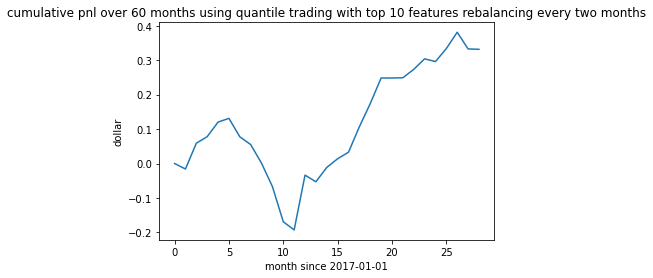

In [204]:
plt.plot(np.cumsum(pnl_all_feature_10_two))
plt.title('cumulative pnl over 60 months using quantile trading with top 10 features rebalancing every two months')
plt.xlabel('month since 2017-01-01')
plt.ylabel('dollar')

In [206]:
pnl_two = quantile_two(data, top_20_feature)

Text(0, 0.5, 'dollar')

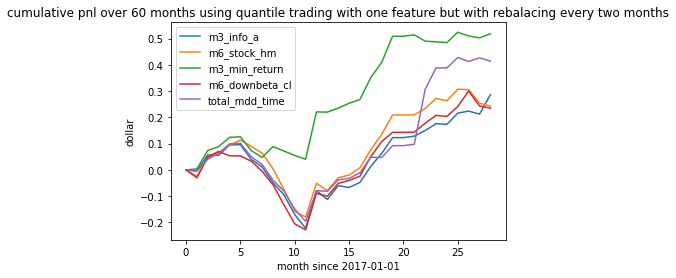

In [208]:
for fea in top_20_feature[-5:]:
    plt.plot(np.cumsum(pnl_two[fea]))
plt.legend(top_20_feature[-5:])
plt.title('cumulative pnl over 60 months using quantile trading with one feature but with rebalacing every two months')
plt.xlabel('month since 2017-01-01')
plt.ylabel('dollar')

In [455]:
import performance_matrix

In [457]:
performance_matrix.performance_matrix()

TypeError: performance_matrix() missing 2 required positional arguments: 'df' and 'metrics'